In [66]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
import sys, os
sys.path.append(os.path.dirname(os.getcwd())) # Include ../SSD in path
import numpy as np
import torch
import matplotlib.pyplot as plt
from vizer.draw import draw_boxes
from tops.config import instantiate, LazyConfig
from ssd import utils
np.random.seed(0)

In [85]:
run = "task2_1"

In [94]:
config_path = f"../configs/{run}.py"
cfg = LazyConfig.load(config_path)

dataset_to_visualize = "train" # or "val"

# THIS NEEDS TO MATCH BATCH USED WHEN TRAINING, else dataloader goes fucking crazy
cfg.train.batch_size = 1

if dataset_to_visualize == "train":
    # Remove GroundTruthBoxesToAnchors transform
    if cfg.data_train.dataset._target_ == torch.utils.data.ConcatDataset:
        for dataset in cfg.data_train.dataset.datasets:
            dataset.transform.transforms = dataset.transform.transforms[:-1]
    else:
        cfg.data_train.dataset.transform.transforms = cfg.data_train.dataset.transform.transforms[:-1]
    dataset = instantiate(cfg.data_train.dataloader)
    gpu_transform = instantiate(cfg.data_train.gpu_transform)
else:
    cfg.data_val.dataloader.collate_fn = utils.batch_collate
    dataset = instantiate(cfg.data_val.dataloader)
    gpu_transform = instantiate(cfg.data_val.gpu_transform)

# Assumes that the first GPU transform is Normalize
# If it fails, just change the index from 0.
image_mean = torch.tensor(cfg.data_train.gpu_transform.transforms[0].mean).view(1, 3, 1, 1)
image_std = torch.tensor(cfg.data_train.gpu_transform.transforms[0].std).view(1, 3, 1, 1)

It looks like you are currently working on the server, with a 'working directory' in: /work/snotra/mariueng
Saving all SSD outputs to: /work/snotra/mariueng/ssd_outputs
Found dataset directory in: /work/datasets/tdt4265_2022
Found dataset file in: /work/datasets/tdt4265_2022/train_annotations.json
Found dataset directory in: /work/datasets/tdt4265_2022
Found dataset file in: /work/datasets/tdt4265_2022/val_annotations.json


In [95]:
sample = next(iter(dataset))
sample = gpu_transform(sample)

Type in resize: tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.1765, 0.1961, 0.1216,  ..., 0.2392, 0.1059, 0.0706],
         [0.1843, 0.2118, 0.2471,  ..., 0.3059, 0.1882, 0.2275],
         [0.2314, 0.2039, 0.0157,  ..., 0.2392, 0.1569, 0.1137]],

        [[0.7725, 0.7569, 0.7686,  ..., 0.8431, 0.7412, 0.6941],
         [0.6980, 0.7137, 0.6667,  ..., 0.7412, 0.7020, 0.7333],
         [0.7255, 0.7529, 0.7412,  ..., 0.6863, 0.7373, 0.7137],
         ...,
         [0.3490, 0.2353, 0.1843,  ..., 0.3765, 0.2667, 0.2196],
         [0.2902, 0.2667, 0.3255,  ..., 0.3216, 0.3608, 0.2471],
         [0.2863, 0.2118, 0.2980,  ..., 0.3255, 0.2510, 0.2902]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0039, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0039],
         [0.0000, 0.0000, 0.0000,  ..., 0.

In [96]:
model = instantiate(cfg.model)
#device = torch.device(str("cuda:0") if torch.cuda.is_available() else "cpu") 
#model = model.to(device)

In [97]:
#next(model.parameters()).is_cuda

In [98]:
# Create dummy input
#dummy_input = torch.rand(1, 3, 128, 1024)
#shape = torch.Size((1, 3, 128, 1024))
#dummy_input = torch.cuda.FloatTensor(shape)
#torch.randn(shape, out=dummy_input)
#print(dummy_input.is_cuda)
#print(type(dummy_input))

In [113]:
image = sample["image"] #.to("cuda")
#image.is_cuda

False

In [117]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs"
writer = SummaryWriter(f'runs/{run}')
writer.add_graph(model.cuda(), image.to("cuda"))
writer.close()

Only tensors, lists, tuples of tensors, or dictionary of tensors can be output from traced functions
Error occurs, No graph saved


RuntimeError: Only tensors, lists, tuples of tensors, or dictionary of tensors can be output from traced functions

In [81]:
transforms = cfg.data_train.dataset.transform.transforms

In [82]:
for t in transforms:
    print(t)

{'_target_': <class 'ssd.data.transforms.transform.ToTensor'>}
{'imshape': '${train.imshape}', '_target_': <class 'ssd.data.transforms.transform.Resize'>}


In [104]:
print("The first sample in the dataset has the following keys:", sample.keys())
for key, item in sample.items():
    print(
        key, ": shape=", item.shape if hasattr(item, "shape") else "", 
        " dtype=", item.dtype if hasattr(item, "dtype") else type(item), sep="")


The first sample in the dataset has the following keys: dict_keys(['image', 'boxes', 'labels', 'width', 'height', 'image_id'])
image: shape=torch.Size([1, 3, 128, 1024]) dtype=torch.float32
boxes: shape=torch.Size([1, 13, 4]) dtype=torch.float32
labels: shape=torch.Size([1, 13]) dtype=torch.int64
width: shape=torch.Size([1]) dtype=torch.int64
height: shape=torch.Size([1]) dtype=torch.int64
image_id: shape=torch.Size([1]) dtype=torch.int64


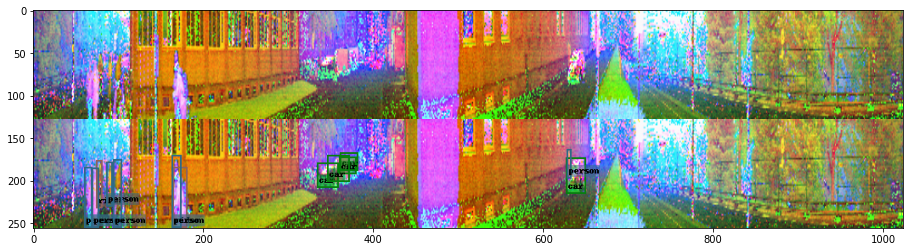

In [105]:
# Convert image to HWC byte
image = (sample["image"] * image_std + image_mean)
image = (image * 255).byte()[0]
im = image.permute(1, 2, 0).cpu().numpy()

# Convert boxes to pixel coordinates
boxes = sample["boxes"][0]
boxes[:, [0, 2]] *= image.shape[-1]  # width
boxes[:, [1, 3]] *= image.shape[-2]  # height

# Draw boxes on image, params: image, boxes with pixel coordinates, label value, label names.
im_with_boxes = draw_boxes(im, boxes.cpu().numpy(), sample["labels"][0].cpu().numpy().tolist(), class_name_map=cfg.label_map)

concat_im = np.concatenate([im, im_with_boxes], axis=0)

#fig, ax = plt.subplot(figsize=(18, 2))
#plt.imshow(im)
fig, ax = plt.subplots(figsize=(36, 4))
ax.imshow(concat_im)
#plt.show()

In [120]:
import torchvision
############## TENSORBOARD ########################
img_grid = torchvision.utils.make_grid(image)
writer.add_image('mnist_images', img_grid)
#writer.close()
#sys.exit()
###################################################

In [123]:
############## TENSORBOARD ########################
writer.add_graph(model, image)
#writer.close()
#sys.exit()
###################################################

Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor
Error occurs, No graph saved


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor